In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocess as mp
import numpy as np
import pandas as pd
import pypairix
import bioframe
import cooltools
import cooltools.insulation
import cooler
import re

import time

In [38]:
chr_list = ["chr2R", "chr2L", "chr3R", "chr3L", "chr4", "chrX"]
    
dm6 = pd.read_csv("../../reference/dm6.chrom.sizes",sep='\t',squeeze=True,index_col=0,header=None)
chromsizes = pd.read_csv("../../reference/dm6.chrom.sizes",sep='\t',squeeze=True,header=None,index_col=0)

#ヘテロクロマチン領域の良くわからないcontigを弾く
chromsizes = chromsizes[chromsizes > 1000000]
dm6 = dm6[dm6 > 1000000]

chromosomes = list(chromsizes.index)

binsize = 10000
flank = binsize*50

In [39]:
chromosomes

['chr2L', 'chr2R', 'chr3L', 'chr3R', 'chr4', 'chrX', 'chrY']

In [46]:
resolution_list=[200,400,600,800,1000,2000,4000,10000,20000,50000]

In [48]:
cool_E = []
cool_N = []
cool_All = []
for i, resol in enumerate(resolution_list):
    cool_E.append(cooler.Cooler("../results/coolers_library_group/siE_library.dm6.mapq_30.200.mcool::resolutions/"+str(resol)))
    cool_N.append(cooler.Cooler("../results/coolers_library_group/siN_library.dm6.mapq_30.200.mcool::resolutions/"+str(resol)))
    cool_All.append(cooler.Cooler("../results/coolers_library_group/siAll_library.dm6.mapq_30.200.mcool::resolutions/"+str(resol)))

Insulation score(from Hsieh THS Mol Cell 2020)の方法を真似る。
200-50000bpのresolutionに対してresolutionの10,25,50,100倍のbinsizeで調べる。

window sizeをlistで指定するとむちゃくちゃ遅い、for文で回す。

In [ ]:
resolution_mul_list = [10,25,50,100]
for i, resol in enumerate(resolution_list):
    for k in resolution_mul_list:
        window_size = resol*k
        print("resolution:"+str(resol))
        print("window:"+str(resol*k))
        startTime = time.time()

        insulate_E = cooltools.insulation.calculate_insulation_score(cool_E[i],window_size,chromosomes=chromosomes,verbose=True)
        insulate_E.to_csv("../insulation_score/E_ins_score_"+str(resol)+"_window"+str(window_size)+".csv")

        insulate_N = cooltools.insulation.calculate_insulation_score(cool_N[i],window_size,chromosomes=chromosomes,verbose=True)
        insulate_N.to_csv("../insulation_score/N_ins_score_"+str(resol)+"_window"+str(window_size)+".csv")

        insulate_All = cooltools.insulation.calculate_insulation_score(cool_All[i],window_size,chromosomes=chromosomes,verbose=True)
        insulate_All.to_csv("../insulation_score/All_ins_score_"+str(resol)+"_window"+str(window_size)+".csv")
        endTime = time.time()
        
        print(endTime-startTime)


とりあえずInsulate scoreを解像度毎にまとめる。その上で、heatmapを作成

In [71]:
sample_list = ["E","N","All"]

for sample in sample_list:
    for i, resol in enumerate(resolution_list):
        res = []
        #csv fileのロード
        for k in resolution_mul_list:
            window_size = resol*k
            res.append(pd.read_csv("../insulation_score/raw_data/"+sample+"_ins_score_"+str(resol)+"_window"+str(window_size)+".csv",index_col=0))
        
        temp1 = pd.merge(res[0],res[1],on=["chrom","start","end","is_bad_bin"])
        temp2 = pd.merge(temp1,res[2],on=["chrom","start","end","is_bad_bin"])
        temp3 = pd.merge(temp2,res[3],on=["chrom","start","end","is_bad_bin"])
    
        temp3.to_csv("../insulation_score/"+sample+"_ins_score_"+str(resol)+".csv")

In [91]:
temp3.iloc[440:]

,chrom,start,end,is_bad_bin,log2_insulation_score_500000,n_valid_pixels_500000,log2_insulation_score_1250000,n_valid_pixels_1250000,log2_insulation_score_2500000,n_valid_pixels_2500000,log2_insulation_score_5000000,n_valid_pixels_5000000
440,chr2L,22000000,22050000,False,2.236467,29.0,2.467887,87.0,2.234320,231.0,2.026419,531.0
441,chr2L,22050000,22100000,False,2.042250,24.0,2.311704,72.0,2.084072,192.0,1.894796,442.0
442,chr2L,22100000,22150000,False,1.737363,15.0,1.898363,61.0,1.771403,153.0,1.609081,353.0
443,chr2L,22150000,22200000,False,1.307722,8.0,1.447450,46.0,1.344680,115.0,1.218399,265.0
444,chr2L,22200000,22250000,True,NaN,0.0,0.510214,30.0,0.418284,76.0,0.325872,176.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2749,chrY,3450000,3500000,True,NaN,0.0,NaN,8.0,NaN,28.0,NaN,64.0
2750,chrY,3500000,3550000,False,NaN,2.0,NaN,10.0,NaN,26.0,NaN,66.0
2751,chrY,3550000,3600000,False,NaN,3.0,NaN,9.0,NaN,21.0,NaN,51.0
2752,chrY,3600000,3650000,False,NaN,3.0,NaN,7.0,NaN,13.0,NaN,35.0


In [129]:
import seaborn as sns
import math

resolution = 4000
test = pd.read_csv("../insulation_score/Total_data/E_ins_score_"+str(resolution)+".csv",index_col=0)
test.loc[:,["log2_insulation_score_"+str(resolution*resolution_mul_list[0]),
            "log2_insulation_score_"+str(resolution*resolution_mul_list[1]),
            "log2_insulation_score_"+str(resolution*resolution_mul_list[2]),
            "log2_insulation_score_"+str(resolution*resolution_mul_list[3])]].corr()

,log2_insulation_score_40000,log2_insulation_score_100000,log2_insulation_score_200000,log2_insulation_score_400000
log2_insulation_score_40000,1.000000,0.745467,0.565308,0.461181
log2_insulation_score_100000,0.745467,1.000000,0.900137,0.789956
log2_insulation_score_200000,0.565308,0.900137,1.000000,0.941263
log2_insulation_score_400000,0.461181,0.789956,0.941263,1.000000


In [131]:
test["log2_insulation_score_40000"].sum()

349.83291585044657

In [132]:
test["log2_insulation_score_100000"].sum()

2012.0508121693244

In [133]:
test["log2_insulation_score_200000"].sum()

4529.114506594298

In [134]:
test["log2_insulation_score_400000"].sum()

6757.990655943681

In [102]:
#bedgraphで出力するファイルを作成

for k in resolution_mul_list:
    content = 'track type=bedGraph name="BedGraph Format" description="BedGraph format" visibility=full color=200,100,0 altColor=0,100,200 priority=20\n'
    for index, row in test.iterrows():
        if row["is_bad_bin"] == False and not math.isnan(row["log2_insulation_score_"+str(resolution*k)]):
            content = content + row["chrom"]+'\t'+str(row["start"])+'\t'+str(row["end"])+'\t'+str(row["log2_insulation_score_"+str(resolution*k)])+'\n'

    f = open('../insulation_score/res'+str(resolution)+'_window'+str(k)+'.bdg', 'w')
    f.write(content)
    f.close()

IGVで比較。相関係数のわりに、最小の点はそんなに変わらない。
あとは見た目の問題だが、x10のwindowで特に問題なさそう。
だけど、ノイズが多い気がするのでx25を使用

In [167]:
import math
mul_factor = 25
for sample in sample_list:
    for i, resol in enumerate(resolution_list):
        test = pd.read_csv("../insulation_score/Total_data/"+sample+"_ins_score_"+str(resol)+".csv",index_col=0)

        f = open('../insulation_score/'+sample+'_res'+str(resol)+'_window'+str(mul_factor)+'.bdg', 'w')
        f.write('track type=bedGraph name="BedGraph Format" description="BedGraph format" visibility=full color=200,100,0 altColor=0,100,200 priority=20\n')
        for index, row in test.iterrows():
            if row["is_bad_bin"] == False and not math.isnan(row["log2_insulation_score_"+str(resol*mul_factor)]):
                f.write(row["chrom"]+'\t'+str(row["start"])+'\t'+str(row["end"])+'\t'+str(row["log2_insulation_score_"+str(resol*mul_factor)])+'\n')
        f.close()

それぞれのinsulation scoreから、Boundaryを検出

In [168]:
for i, resol in enumerate(resolution_list):

    test = pd.read_csv("../insulation_score/raw_data/E_ins_score_"+str(resol)+"_window"+str(resol*mul_factor)+".csv",index_col=0)
    boundary = cooltools.insulation.find_boundaries(test).dropna(subset=["boundary_strength_"+str(resol*mul_factor)])

    boundary["name"] = "boundary"
    cutoff = boundary["boundary_strength_"+str(resol*mul_factor)].mean()
    print(cutoff)

    boudary_out = boundary[(boundary["is_bad_bin"]==False) & (boundary["boundary_strength_"+str(resol*mul_factor)] > cutoff)].loc[:,["chrom","start","end","name","boundary_strength_"+str(resol*mul_factor)]]
    boudary_out.to_csv("../insulation_score/E_res"+str(resol)+"_window"+str(mul_factor)+"_boundary.bed",sep="\t",header=False, index=False)


0.1266741387490575
0.16394953414195884
0.193776568409469
0.22024946693031655
0.23589398767493985
0.30151675500047553
0.3407904395112674
0.37586725810455546
0.3688364481320071
0.2776641048047136


KDで何が起こるかをみるため、Insulation scoreの差を取る(Window sizeはx25で)。

In [202]:
mul_factor = 25

resol = 400
diff_file_E = pd.read_csv("../insulation_score/Total_data/E_ins_score_"+str(resol)+".csv",index_col=0)
diff_file_N = pd.read_csv("../insulation_score/Total_data/N_ins_score_"+str(resol)+".csv",index_col=0)
Total_diff = pd.merge(diff_file_E,diff_file_N,on=["chrom","start","end","is_bad_bin"],suffixes=['_E', '_N'])
Total_diff["diff"] = Total_diff["log2_insulation_score_"+str(mul_factor*resol)+"_E"] - Total_diff["log2_insulation_score_"+str(mul_factor*resol)+"_N"]

#あやしいtileをはずす
Total_diff = Total_diff[(Total_diff["is_bad_bin"] == False) & (Total_diff["n_valid_pixels_"+str(resol*mul_factor)+"_E"]>600)]

In [228]:
print(Total_diff.shape)

upper_limit = Total_diff["diff"].quantile(0.999)
lower_limit = Total_diff["diff"].quantile(0.001)

print(upper_limit)
print(lower_limit)

(205182, 21)
0.21902441695586228
-0.21284889063085463


<AxesSubplot:xlabel='diff', ylabel='Count'>

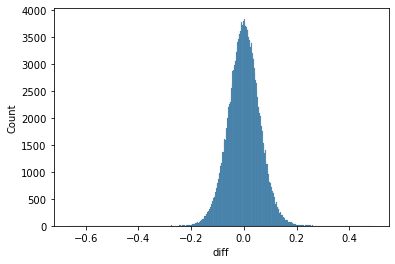

In [229]:
sns.histplot(Total_diff["diff"])

In [230]:
insulate_up = Total_diff[Total_diff["diff"] > upper_limit]
insulate_up["name"] = "change"

insulate_down = Total_diff[Total_diff["diff"] < lower_limit]
insulate_down["name"] = "change"

<ipython-input-230-89a1d7f8aa5d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insulate_up["name"] = "change"
<ipython-input-230-89a1d7f8aa5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insulate_down["name"] = "change"


In [231]:
insulate_down["diff"].mean()

-0.2625364567468008

In [232]:
insulate_up.to_csv("../insulation_score/insulation_up.bed",columns=["chrom","start","end","name","diff"],sep="\t",header=False, index=False)
insulate_down.to_csv("../insulation_score/insulation_down.bed",columns=["chrom","start","end","name","diff"],sep="\t",header=False, index=False)